# MedInfo 2019 Practical 1
****
In this practical session, we begin to explore some of the concepts covered in the lectures and give you the opportunity to run some code.

Practical 1 focuses on building a logistic regression model and highlights some key steps and decisions that are needed when developing a logistic prediction model.

We will begin by loading our data set and perform some integrity checks. Some exploratoty analysis will then be conducted to gain an understanding of the data. Once we are happy and familiar with the data we begin by showing you how to conduct univariate logistic regression models for categorical predictor variables. Following this we will explore inivariate regression with a continuous variable and how to decide if the association between the dependent and independent variable is linear or non-linear. Finally, we will build a multivariable prediction model.

If you are versed in R and regression then once you load the data you can skip to part 4 (univatriate regression with continuous variables).

## The data

For todays practicals we will be using data from the Second Manifestations of ARTerial disease (SMART) study  
Here is a [link](https://link.springer.com/article/10.1023/A:1007621514757) to more information about the study.

| Variable | Description |
| :--- | :--- |
|TEVENT| Time of event (days) |
|EVENT| Cardiovascular event (0=no, 1=yes) |
|outcome| Cardiovascular event within 2 years of study entry (0=no, 1=yes) |
|SEX| 1 = male, 2 = female|
|AGE|Age (years)|
|DIABETES| Ever diabetes (0=no, 1=yes) |
|CEREBRAL| Ever cerebrovascular disease (0=no, 1=yes) |
|CARDIAC| Ever cardiovascular disease (0=no, 1=yes) |
|AAA| Ever abdominal aortic aneurysm (0=no, 1=yes) |
|PERIPH| Ever periferal aortic aneurysm (0=no, 1=yes) |
|STENOSIS| Ever periferal vascular disease (0=no, 1=yes) |
|SYSTBP| Systolic blood pressure (automatic, mm Hg)|
|DIASTBP| Diastolic blood pressure (automatic, mm Hg)|
|SYSTH| Systolic blood pressure (by hand, mm Hg)|
|DIASTH| Diastolic blood pressure (by hand, mm Hg)|
|LENGTHO| Height (m)|
|WEIGHTO| Weight (kg)|
|BMIO| Body mass index ($kg/m^2$)|
|CHOLO|Cholesterol level (mmol/L)|
|albumin| Albumin in urine (1=no, 2=low, 3=high)
|SMOKING| Smoking status (1=no, 2=Former, 3=current)
|packsyrs| Packetyears smoked|
|alcohol| Alcohol consumption (1=no, 2=Former, 3=current)|




The data was made freely available by Ewout Steyerberg who used the SMART data in his book 'Clinical prediction models: A Practical Approach to Development, Validation and Updating'. The data set is available from http://http://www.clinicalpredictionmodels.org/ but has been formated to make them easier for you to use. 

## Lets begin

First lets load the packages we will be using in the practical

In [1]:
#install.packages("reshape")

In [1]:
library(ggplot2)
library(plyr)
library(rms)
library(MASS)
library(reshape)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'rms' was built under R version 3.6.1"Loading required package: Hmisc
Warning message:
"package 'Hmisc' was built under R version 3.6.1"Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:plyr':

    is.discrete, summarize

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: SparseM

Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve

Warning message:
"package 'reshape' was built under R version 3.6.1"
Attaching package: 'reshape'

The following objects are masked from 'package:plyr':

    rename, round_any



## Part 1 load and clean the data
Load the data and perform some data checks

In [2]:
smart <- readRDS(file= "SMARTs_medinfo_P1.rds")
class(smart) # This tells us the class/data type of the object smart (hopefully returning data.frame)
dim(smart)
sapply(smart,class) # This tells us the class of each variable in the smart data, eg, categorical='factor' or continuous='numeric'

[1] "data.frame"

TEVENT     EVENT       SEX       AGE  DIABETES  CEREBRAL   CARDIAC       AAA 
"numeric" "integer"  "factor" "integer"  "factor"  "factor"  "factor"  "factor" 
   PERIPH  STENOSIS    SYSTBP   DIASTBP     SYSTH    DIASTH   LENGTHO   WEIGHTO 
 "factor"  "factor" "integer" "integer" "integer" "integer" "numeric" "integer" 
     BMIO     CHOLO   albumin   SMOKING   packyrs   alcohol   outcome 
"numeric" "numeric" "integer"  "factor" "numeric"  "factor" "integer"

Albumin is not a factor variable so we need to change and label

In [3]:
# Albumin
smart$albumin <- as.factor(smart$albumin)
levels(smart$albumin)
smart$albumin <- revalue(smart$albumin, c("1"="No", "2"="Low", "3"="High"))
levels(smart$albumin)

[1] "1" "2" "3"

[1] "No"   "Low"  "High"

There are 2 variables for systolic blood pressure (SBP) because it can either done by hand or automatic. If we check, we can see there is alot of missing data in both of the SBP variables.

In [4]:
table(is.na(smart$SYSTBP)==FALSE)
table(is.na(smart$SYSTH)==FALSE)


FALSE  TRUE 
 1223  2650 


FALSE  TRUE 
 1498  2375 

However, if we look at how many individuals have SBP recorded by atleast one of the methods we find all but 3 have atleast one SBP measurement.

In [5]:
table(is.na(smart$SYSTH)==FALSE | is.na(smart$SYSTBP)==FALSE)


FALSE  TRUE 
    3  3870 

 We can combine both of these variables to create a new SBP variable, such that, the variable will use the automatic SBP reading for each individual unless it is missing and then it will replace the missing indicator with the SBP recorded by hand.

In [6]:
smart$SBP <- ifelse(is.na(smart$SYSTBP)==FALSE, smart$SYSTBP, smart$SYSTH)
table(is.na(smart$SBP))


FALSE  TRUE 
 3870     3 

## Part 2 Exploratory analysis
Now the data has been 'cleaned' we can begin to provide overviews of the data see the number of events/outcomes in our data.  

In [7]:
# Overview of the data
attach(smart)
dim(smart)
summary(smart)
sapply(smart,class)
describe(smart)	

# Summarise outcome
table(outcome)
round(prop.table(table(outcome))*100,0)

[1] 3873   24

     TEVENT           EVENT            SEX            AGE        DIABETES   
 Min.   :   0.1   Min.   :0.0000   Female: 976   Min.   :19.00   0   :2987  
 1st Qu.: 555.0   1st Qu.:0.0000   Male  :2897   1st Qu.:52.00   1   : 846  
 Median :1213.0   Median :0.0000                 Median :60.00   NA's:  40  
 Mean   :1370.3   Mean   :0.1188                 Mean   :59.56              
 3rd Qu.:2165.0   3rd Qu.:0.0000                 3rd Qu.:68.00              
 Max.   :3466.0   Max.   :1.0000                 Max.   :82.00              
                                                                            
 CEREBRAL CARDIAC  AAA      PERIPH   STENOSIS        SYSTBP     
 0:2726   0:1713   0:3457   0:2933   0   :3058   Min.   : 96.0  
 1:1147   1:2160   1: 416   1: 940   1   : 722   1st Qu.:127.0  
                                     NA's:  93   Median :139.0  
                                                 Mean   :141.3  
                                                 3rd Qu.:15

TEVENT     EVENT       SEX       AGE  DIABETES  CEREBRAL   CARDIAC       AAA 
"numeric" "integer"  "factor" "integer"  "factor"  "factor"  "factor"  "factor" 
   PERIPH  STENOSIS    SYSTBP   DIASTBP     SYSTH    DIASTH   LENGTHO   WEIGHTO 
 "factor"  "factor" "integer" "integer" "integer" "integer" "numeric" "integer" 
     BMIO     CHOLO   albumin   SMOKING   packyrs   alcohol   outcome       SBP 
"numeric" "numeric"  "factor"  "factor" "numeric"  "factor" "integer" "integer"

smart 

 24  Variables      3873  Observations
--------------------------------------------------------------------------------
TEVENT 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    3873        0     1934        1     1370     1078     98.6    197.0 
     .25      .50      .75      .90      .95 
   555.0   1213.0   2165.0   2762.4   3017.4 

lowest :    0.1    1.0    2.0    3.0    4.0, highest: 3451.0 3452.0 3463.0 3465.0 3466.0
--------------------------------------------------------------------------------
EVENT 
       n  missing distinct     Info      Sum     Mean      Gmd 
    3873        0        2    0.314      460   0.1188   0.2094 

--------------------------------------------------------------------------------
SEX 
       n  missing distinct 
    3873        0        2 
                        
Value      Female   Male
Frequency     976   2897
Proportion  0.252  0.748
-----------------------------------------------------------------------------

outcome
   0    1 
3661  212 

outcome
 0  1 
95  5 

We see that 212 (5%) individuals have the outcome of interest.  
It can be useful to also summarise each variable by the outcome

In [8]:
# Summarise categorical variables by outcome
table(SEX,outcome) # Produces a table of counts
round(prop.table(table(SEX,outcome),2)*100,0) # Produces a table of percentages
round(prop.table(table(outcome,SEX),2)*100,0) # Produces a table of percentages

table(SMOKING,outcome) 
round(prop.table(table(SMOKING,outcome),2)*100,0)
round(prop.table(table(outcome,SMOKING),2)*100,0)

        outcome
SEX         0    1
  Female  933   43
  Male   2728  169

        outcome
SEX       0  1
  Female 25 20
  Male   75 80

       SEX
outcome Female Male
      0     96   94
      1      4    6

         outcome
SMOKING      0    1
  Current  423   21
  Former  2562  149
  Never    654   39

         outcome
SMOKING    0  1
  Current 12 10
  Former  70 71
  Never   18 19

       SMOKING
outcome Current Former Never
      0      95     95    94
      1       5      5     6

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


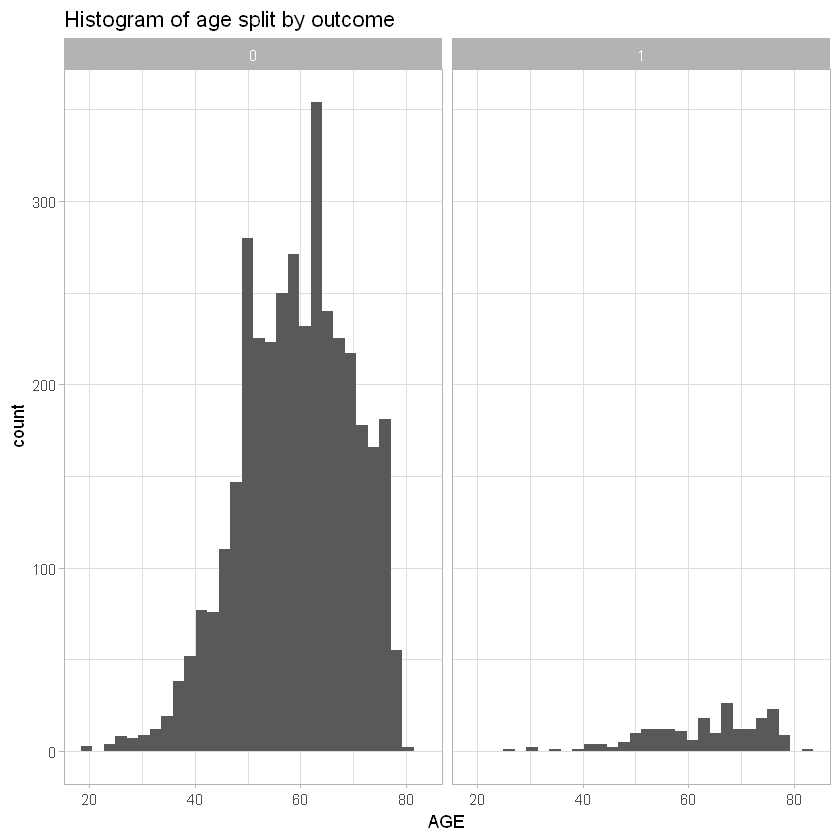

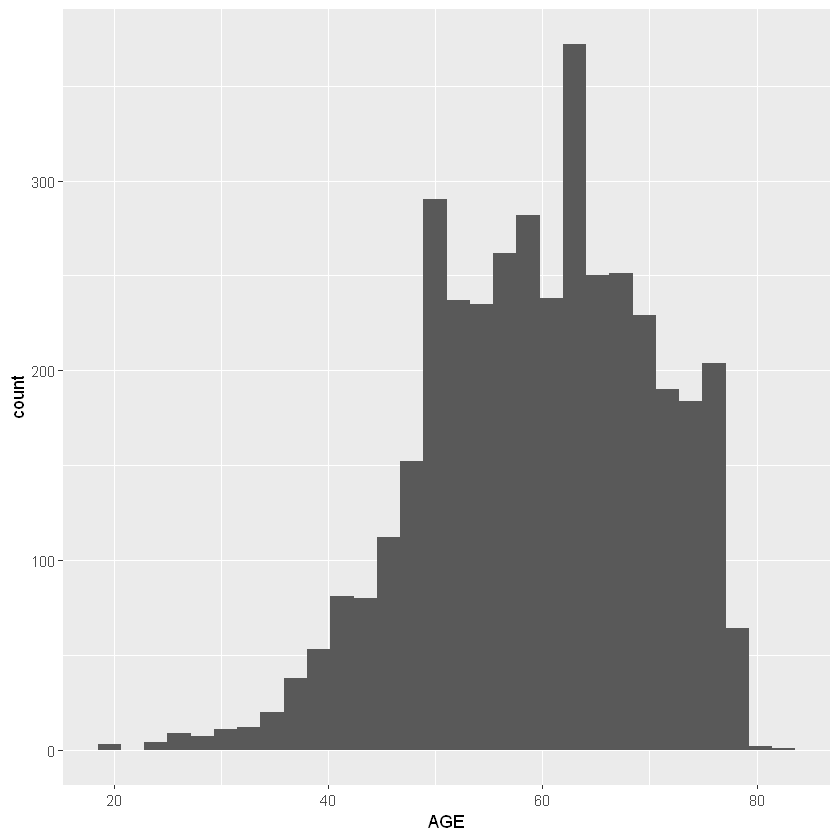

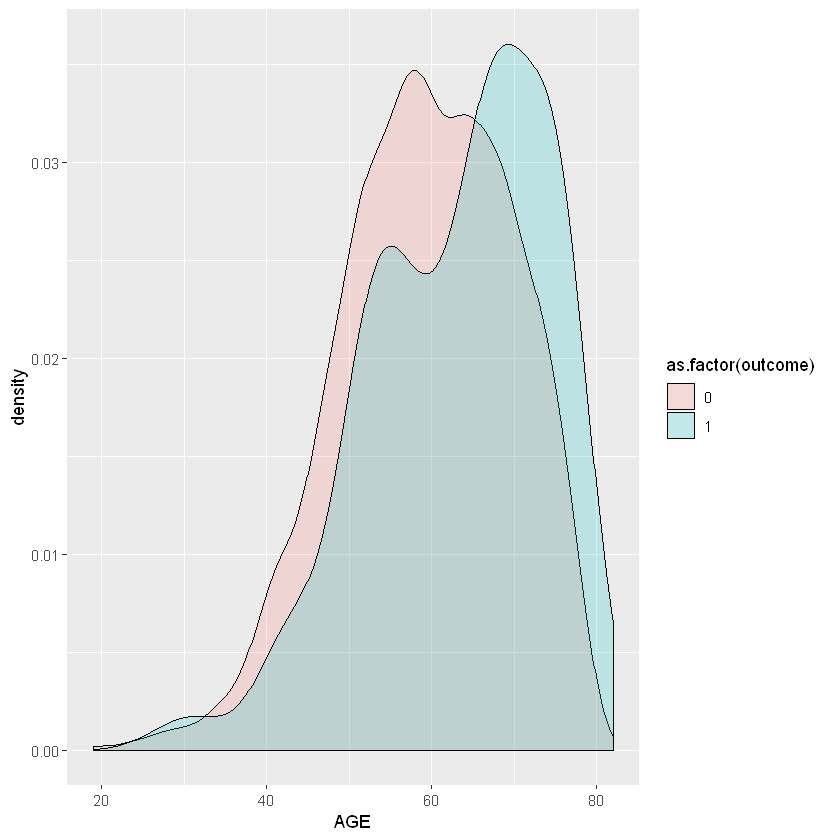

In [9]:
# Look at distributions of continuous variables
ggplot(smart,aes(x=AGE))+geom_histogram()+facet_grid(~outcome)+theme_light()+ labs(title = "Histogram of age split by outcome")
ggplot(smart, aes(AGE, fill = outcome)) + geom_histogram()
ggplot(smart, aes(AGE, fill = as.factor(outcome))) + geom_density(alpha = 0.2)


## Part 3 Univariate logistic regression with categorical variables
Lets start by producing a univariate logistic model with gender as the independant variable.

In [10]:
detach(smart)
# Univariable models for categorical variables

# Recode SEX so that the baseline is male #
smart$SEX2 = relevel(smart$SEX, ref="Male")
attach(smart)

# logistic regression model including sex as the only independent variable
sex_mod <- glm(outcome~SEX2,family="binomial")
summary(sex_mod)
beta <- round(exp(sex_mod$coef),3) # extract the model coefficients from the model
b <- round(exp(confint.default(sex_mod)),3) # Compute the confidence intervals for the model coefficients
d <- cbind(beta,b)
d


Call:
glm(formula = outcome ~ SEX2, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3467  -0.3467  -0.3467  -0.3002   2.4989  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.78143    0.07927 -35.088   <2e-16 ***
SEX2Female  -0.29578    0.17494  -1.691   0.0909 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1644  on 3872  degrees of freedom
Residual deviance: 1641  on 3871  degrees of freedom
AIC: 1645

Number of Fisher Scoring iterations: 5


,beta,2.5 %,97.5 %
(Intercept),0.062,0.053,0.072
SEX2Female,0.744,0.528,1.048


Can you interpret the output?

**By modifying the code above, try fitting a logistic regression model to the SMART data with albumin as the predictor.**  
**Q. Interpret the output. Is albumin a significant predictor? What level of albumin is associated with the lowest risk?**

In [12]:
# Insert R code here

## Part 4 Univariate logistic regression with continuous variables
Now lets try with a continuous variable (AGE).  

In [11]:
# Assuming age is linear
age_mod <- glm(outcome~AGE,family="binomial")
summary(age_mod)
exp(confint.default((age_mod))) # if you want confidence intervals for the model coefficients


Call:
glm(formula = outcome ~ AGE, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4787  -0.3721  -0.3215  -0.2775   2.8832  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.15648    0.46657 -11.052  < 2e-16 ***
AGE          0.03763    0.00732   5.141 2.74e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1644.0  on 3872  degrees of freedom
Residual deviance: 1615.8  on 3871  degrees of freedom
AIC: 1619.8

Number of Fisher Scoring iterations: 6


,2.5 %,97.5 %
(Intercept),0.002308999,0.01437844
AGE,1.023553684,1.05334708


If you wanted to calculate the models average predicted risk for a 40 year old or an 80 year old you can do this using the code below.

In [12]:
lp40 <- predict(age_mod,data.frame(AGE=40))
risk40 <- exp(lp40)/(1+exp(lp40))*100

lp80 <- predict(age_mod,data.frame(AGE=80))
risk80 <- exp(lp80)/(1+exp(lp80))*100


matrix(c("risk40","risk80", risk40, risk80),ncol=2,byrow=F)

risk40,2.52977615539029
risk80,10.467289852795


We see that on average, a 40 year old individual has a 2.5% risk of a cardiovascular event within 2 years.  
Alternatively, you can also use this code to obtain the risk for an individual who is 40 years old. The results are the same, it is just another way to calculate the risk.

In [13]:
risk40a <- predict(age_mod,data.frame(AGE=40), type="response")*100 
# 'type="response"' gives the predicted probabilites and so multiply by 100 to get the risk as a percentage
risk40b <- 1/(1+exp(-lp40))*100 # alternative calculation
c(risk40a, risk40b)

1        1 
2.529776 2.529776

## Part 5 Modelling a continuos variable using splines

Lets model age using splines.  

First create spline variables, where 3 means 3 knots (i.e. 2 age terms) etc.

In [14]:
age3_spline <- rcs(AGE,3)
age4_spline <- rcs(AGE,4)
age5_spline <- rcs(AGE,5)

Fit a logistic regression model using each set of spline variables & predict the linear predictor (LP)

In [15]:
lp_age1 <- predict(age_mod)

age3_mod <- glm(outcome~age3_spline,family="binomial")
age3_mod
lp_age3 <- predict(age3_mod)

age4_mod <- glm(outcome~age4_spline,family="binomial")
age4_mod
lp_age4 <- predict(age4_mod)

age5_mod <- glm(outcome~age5_spline,family="binomial")
age5_mod
lp_age5 <- predict(age5_mod)


Call:  glm(formula = outcome ~ age3_spline, family = "binomial")

Coefficients:
    (Intercept)   age3_splineAGE  age3_splineAGE'  
      -3.014784        -0.004786         0.051368  

Degrees of Freedom: 3872 Total (i.e. Null);  3870 Residual
Null Deviance:	    1644 
Residual Deviance: 1608 	AIC: 1614


Call:  glm(formula = outcome ~ age4_spline, family = "binomial")

Coefficients:
     (Intercept)    age4_splineAGE   age4_splineAGE'  age4_splineAGE''  
       -3.439183          0.004632          0.010750          0.158339  

Degrees of Freedom: 3872 Total (i.e. Null);  3869 Residual
Null Deviance:	    1644 
Residual Deviance: 1608 	AIC: 1616


Call:  glm(formula = outcome ~ age5_spline, family = "binomial")

Coefficients:
      (Intercept)     age5_splineAGE    age5_splineAGE'   age5_splineAGE''  
         -3.76956            0.01277           -0.04864            0.45158  
age5_splineAGE'''  
         -0.63407  

Degrees of Freedom: 3872 Total (i.e. Null);  3868 Residual
Null Deviance:	    1644 
Residual Deviance: 1607 	AIC: 1617

Plot all LPs together for visual inspection (including the linear model)

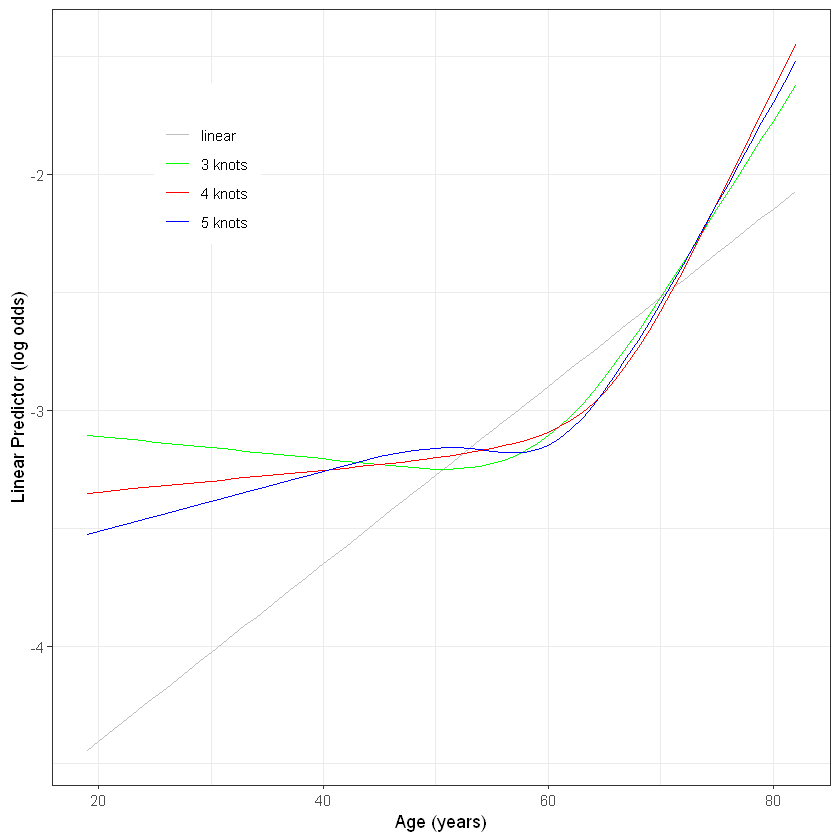

In [18]:
data_part6 <- data.frame(AGE,lp_age1,lp_age3,lp_age4,lp_age5)
data_part6_m <- melt(data_part6,id.vars='AGE')
plot_part6 <- ggplot(data_part6_m,aes(AGE,value,colour=variable))+geom_line()+scale_colour_manual(labels=c("linear","3 knots","4 knots","5 knots"),values=c("gray","green","red","blue"))+theme_bw()
plot_part6 + labs(x="Age (years)",y="Linear Predictor (log odds)",color="") + theme(legend.position=c(0.2,0.8))

From this graph which term would you use to model age? Do you think age is linear?  
We can check which is the best fitted model and most appropriate term to use for age by comparing AIC or BIC

In [16]:
age_spline_check <- matrix(c(AIC(age_mod),
         BIC(age_mod),
         AIC(age3_mod),
         BIC(age3_mod),
         AIC(age4_mod),
         BIC(age4_mod),
         AIC(age5_mod),
         BIC(age5_mod)), ncol=2, byrow=TRUE)

colnames(age_spline_check) <- c("AIC", "BIC")
rownames(age_spline_check) <- c("age_mod","age3_mod", "age4_mod", "age5_mod")
age_spline_check

,AIC,BIC
age_mod,1619.782,1632.306
age3_mod,1614.187,1632.972
age4_mod,1615.562,1640.609
age5_mod,1617.404,1648.713


From the AIC we would conclude age should be a non-linear term with three knots

## Part 5 Building a multivariable model

Now we will move beyond univariate analysis and build a model using variable selection.

We will consider the following candidate predictors for inclusion in our model:  
SEX, AGE, SBP, alcohol, CHOLO, BMIO, DIABETES, CARDIAC, SMOKING, AAA  

Below I have subset the data to include only the data we need and removed any individuals with missing data.  
**Note: removing individuals with missing data has been done for simplicity and is not advised in practice. This can induce bias and one should always consider techniques such as multiple imputation if data are missing** 

In [17]:
detach(smart)
smart <- subset(smart, select = c(outcome, SEX, AGE, SBP, alcohol, CHOLO, BMIO, DIABETES, CARDIAC, SMOKING, AAA))
smart <- na.omit(smart)
age3_spline <- rcs(smart$AGE,3)
attach(smart)

Next we can use forward or backward selection to develop a multivariable prediction model.  
We will use a p-value of 0.1 (equivalent to an AIC of 2.706) so not to be too stringent.

In [18]:

k10 <- qchisq(0.10,1,lower.tail=FALSE) # this give the change in AIC we consider to be significant in our stepwise selection

# Forward selection (by AIC)
empty_mod_2 <- glm(outcome~1,family="binomial")
forward_mod_2 <- stepAIC(empty_mod_2,k=k10,scope=list(upper=~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,lower=~1),direction="forward",trace=TRUE)


Start:  AIC=1610.31
outcome ~ 1

              Df Deviance    AIC
+ age3_spline  2   1571.6 1579.7
+ AAA          1   1587.1 1592.5
+ SBP          1   1599.9 1605.3
+ DIABETES     1   1600.9 1606.3
+ SEX          1   1604.1 1609.5
+ alcohol      2   1601.8 1609.9
<none>             1607.6 1610.3
+ BMIO         1   1605.3 1610.7
+ CHOLO        1   1606.7 1612.1
+ CARDIAC      1   1607.6 1613.0
+ SMOKING      2   1607.2 1615.3

Step:  AIC=1579.7
outcome ~ age3_spline

           Df Deviance    AIC
+ AAA       1   1560.6 1571.4
+ DIABETES  1   1567.0 1577.8
+ SEX       1   1567.9 1578.7
<none>          1571.6 1579.7
+ SBP       1   1570.6 1581.4
+ BMIO      1   1570.6 1581.4
+ CHOLO     1   1570.9 1581.7
+ alcohol   2   1568.2 1581.7
+ CARDIAC   1   1571.5 1582.4
+ SMOKING   2   1571.5 1585.0

Step:  AIC=1571.4
outcome ~ age3_spline + AAA

           Df Deviance    AIC
+ DIABETES  1   1555.2 1568.7
<none>          1560.6 1571.4
+ SEX       1   1558.2 1571.7
+ SBP       1   1559.2 1572.7
+

In [19]:
# Backward selection (by AIC)
full_mod_2 <- glm(outcome~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,family="binomial")
backward_mod_2 <- stepAIC(full_mod_2,k=k10,scope=list(upper=~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,lower=~1),direction="backward",trace=TRUE)


Start:  AIC=1581.74
outcome ~ SEX + age3_spline + SBP + alcohol + CHOLO + BMIO + 
    DIABETES + CARDIAC + SMOKING + AAA

              Df Deviance    AIC
- SMOKING      2   1543.9 1576.3
- CARDIAC      1   1544.5 1579.6
- CHOLO        1   1544.7 1579.9
- SBP          1   1545.0 1580.1
- alcohol      2   1548.2 1580.7
- BMIO         1   1546.1 1581.2
<none>             1543.9 1581.7
- SEX          1   1548.0 1583.2
- DIABETES     1   1549.4 1584.6
- AAA          1   1554.0 1589.2
- age3_spline  2   1560.7 1593.2

Step:  AIC=1576.34
outcome ~ SEX + age3_spline + SBP + alcohol + CHOLO + BMIO + 
    DIABETES + CARDIAC + AAA

              Df Deviance    AIC
- CARDIAC      1   1544.5 1574.3
- CHOLO        1   1544.7 1574.5
- SBP          1   1545.0 1574.7
- alcohol      2   1548.4 1575.4
- BMIO         1   1546.1 1575.8
<none>             1543.9 1576.3
- SEX          1   1548.1 1577.9
- DIABETES     1   1549.4 1579.2
- AAA          1   1554.0 1583.8
- age3_spline  2   1561.2 1588.2

Step: 

In [20]:
forward_mod_2
backward_mod_2


Call:  glm(formula = outcome ~ age3_spline + AAA + DIABETES, family = "binomial")

Coefficients:
      (Intercept)   age3_splinesmart  age3_splinesmart'               AAA1  
        -2.961038          -0.008679           0.049203           0.667711  
        DIABETES1  
         0.381083  

Degrees of Freedom: 3802 Total (i.e. Null);  3798 Residual
Null Deviance:	    1608 
Residual Deviance: 1555 	AIC: 1565


Call:  glm(formula = outcome ~ age3_spline + DIABETES + AAA, family = "binomial")

Coefficients:
      (Intercept)   age3_splinesmart  age3_splinesmart'          DIABETES1  
        -2.961038          -0.008679           0.049203           0.381083  
             AAA1  
         0.667711  

Degrees of Freedom: 3802 Total (i.e. Null);  3798 Residual
Null Deviance:	    1608 
Residual Deviance: 1555 	AIC: 1565

Here forward and backward selection choose the same model. However, this is not always what happens in practice.   
We can also force a variable to be included in the model.

In [21]:
# Backward selection (by AIC) forcing SEX to be incuded in the model
backward_mod_2sex <- stepAIC(full_mod_2,k=k10,scope=list(upper=~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,lower=~SEX),direction="backward",trace=TRUE)
backward_mod_2sex
summary(backward_mod_2sex)

Start:  AIC=1581.74
outcome ~ SEX + age3_spline + SBP + alcohol + CHOLO + BMIO + 
    DIABETES + CARDIAC + SMOKING + AAA

              Df Deviance    AIC
- SMOKING      2   1543.9 1576.3
- CARDIAC      1   1544.5 1579.6
- CHOLO        1   1544.7 1579.9
- SBP          1   1545.0 1580.1
- alcohol      2   1548.2 1580.7
- BMIO         1   1546.1 1581.2
<none>             1543.9 1581.7
- DIABETES     1   1549.4 1584.6
- AAA          1   1554.0 1589.2
- age3_spline  2   1560.7 1593.2

Step:  AIC=1576.34
outcome ~ SEX + age3_spline + SBP + alcohol + CHOLO + BMIO + 
    DIABETES + CARDIAC + AAA

              Df Deviance    AIC
- CARDIAC      1   1544.5 1574.3
- CHOLO        1   1544.7 1574.5
- SBP          1   1545.0 1574.7
- alcohol      2   1548.4 1575.4
- BMIO         1   1546.1 1575.8
<none>             1543.9 1576.3
- DIABETES     1   1549.4 1579.2
- AAA          1   1554.0 1583.8
- age3_spline  2   1561.2 1588.2

Step:  AIC=1574.26
outcome ~ SEX + age3_spline + SBP + alcohol + CHOLO +


Call:  glm(formula = outcome ~ SEX + age3_spline + DIABETES + AAA, family = "binomial")

Coefficients:
      (Intercept)            SEXMale   age3_splinesmart  age3_splinesmart'  
         -3.08910            0.28009           -0.01034            0.05113  
        DIABETES1               AAA1  
          0.38432            0.63337  

Degrees of Freedom: 3802 Total (i.e. Null);  3797 Residual
Null Deviance:	    1608 
Residual Deviance: 1553 	AIC: 1565


Call:
glm(formula = outcome ~ SEX + age3_spline + DIABETES + AAA, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8149  -0.3478  -0.2852  -0.2656   2.6974  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -3.08910    0.83505  -3.699 0.000216 ***
SEXMale            0.28009    0.18124   1.545 0.122245    
age3_splinesmart  -0.01034    0.01591  -0.650 0.515930    
age3_splinesmart'  0.05113    0.01818   2.812 0.004917 ** 
DIABETES1          0.38432    0.15996   2.403 0.016280 *  
AAA1               0.63337    0.18646   3.397 0.000682 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1607.6  on 3802  degrees of freedom
Residual deviance: 1552.7  on 3797  degrees of freedom
AIC: 1564.7

Number of Fisher Scoring iterations: 6


In this practical we have built a model solely based on statistical results. However, in practice it is advised that both statistical and clinical relevance should be used to build a model. It is advised to build a model using clinical input and include variables that are clinically important even if the predictor does not appear statistically significant in the model